# Spatial niche discovery of multi-modality data

Here we will use spatial ATAC-RNA-seq mouse brain dataset as an example to illustrate how Garfield performs spatial multi-omics integration analysis. Data access: https://www.nature.com/articles/s41586-023-05795-1.

In [1]:
import os
import pandas as pd
import numpy as np

os.chdir('/data2/zhouwg_data/project/Garfield')
os.getcwd()

'/data2/zhouwg_data/project/Garfield'

In [2]:
# load packages
import os
import warnings
import Garfield as gf
import scanpy as sc
from mudata import MuData
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

gf.__version__

'1.0.0'

### Load data

In [3]:
dataset='spatial_atac_rna_seq_mouse_brain'
root_dir = '/pri_exthome/zhouwg/project/spatial_data/spatial_multi-omics'
file_fold = os.path.join(root_dir, str(dataset))
adata_rna = sc.read_h5ad(file_fold + '/spatial_atac_rna_seq_mouse_brain_batch2.h5ad')
adata_rna.var_names_make_unique()
adata_rna

AnnData object with n_obs × n_vars = 9215 × 22914
    obs: 'RNA_clusters', 'ATAC_clusters', 'batch'
    obsm: 'spatial'
    layers: 'counts'

In [4]:
adata_rna.obs = adata_rna.obs.drop(['ATAC_clusters'],axis=1)
adata_rna

AnnData object with n_obs × n_vars = 9215 × 22914
    obs: 'RNA_clusters', 'batch'
    obsm: 'spatial'
    layers: 'counts'

In [5]:
adata_atac = sc.read_h5ad(file_fold + '/spatial_atac_rna_seq_mouse_brain_batch2_atac.h5ad')
adata_atac.var_names_make_unique()
adata_atac

AnnData object with n_obs × n_vars = 9215 × 121068
    obs: 'RNA_clusters', 'ATAC_clusters', 'batch'
    obsm: 'spatial'
    layers: 'counts'

In [6]:
adata_atac.var_names

Index(['chr1:3094734-3095650', 'chr1:3119757-3120179', 'chr1:3120267-3120653',
       'chr1:3121314-3122051', 'chr1:3264998-3265766', 'chr1:3292462-3293293',
       'chr1:3294044-3295081', 'chr1:3300717-3301474', 'chr1:3301682-3302319',
       'chr1:3309769-3310662',
       ...
       'JH584304.1:106380-107258', 'JH584304.1:112856-113752',
       'GL456216.1:13410-14374', 'GL456216.1:16007-16700',
       'GL456216.1:16825-17441', 'GL456216.1:31908-32576',
       'GL456216.1:43983-44510', 'GL456216.1:48771-49683',
       'JH584292.1:12571-13497', 'JH584295.1:1163-1976'],
      dtype='object', length=121068)

In [8]:
# load meta data
meta = pd.read_csv(file_fold + '/spatial_atac_rna_seq_mouse_brain_batch2_cell_type_annotations.csv', index_col=0)

# add meta data
adata_rna.obs = adata_rna.obs.join(meta)
adata_rna

AnnData object with n_obs × n_vars = 9215 × 22914
    obs: 'RNA_clusters', 'batch', 'ATAC_clusters', 'predicted.celltype'
    obsm: 'spatial'
    layers: 'counts'

In [9]:
# 假设 atac_var_name 是 adata 的一个属性，已经是一个 pandas Series
atac_var_name = adata_atac.var_names  # 假设 var_names 中存储了你需要处理的数据

# 分割每个元素
split_data = atac_var_name.str.split(':|-', expand=True).to_frame(index=False)
split_data.index = atac_var_name
# 将分割后的数据转换为 DataFrame 并命名列
split_data.columns = ['chr', 'start', 'end']

# 将处理后的 DataFrame 存储到 adata.var 中
adata_atac.var[['chr', 'start', 'end']] = split_data

mdata = MuData({"rna": adata_rna, "atac": adata_atac})
mdata

MuData object with n_obs × n_vars = 9215 × 143982
  2 modalities
    rna:	9215 x 22914
      obs:	'RNA_clusters', 'batch', 'ATAC_clusters', 'predicted.celltype'
      obsm:	'spatial'
      layers:	'counts'
    atac:	9215 x 121068
      obs:	'RNA_clusters', 'ATAC_clusters', 'batch'
      var:	'chr', 'start', 'end'
      obsm:	'spatial'
      layers:	'counts'

### Integrating spatially resolved transcriptomics data using Garfield

In [10]:
# set workdir #
workdir = '/pri_exthome/zhouwg/project/Garfield_benchmark/results/sp_multimodal/mouse_brain'
gf.settings.set_workdir(workdir)

### modify parameter
user_config = dict(
    ## Input options
    adata_list=mdata,
    profile='spatial',
    data_type='multi-modal',
    sub_data_type=['rna', 'atac'],
    sample_col=None,
    weight=0.8,
    ## Preprocessing options
    graph_const_method='Squidpy', # mu_std, Radius, KNN, Squidpy
    genome='mm10',
    used_hvg=True,
    min_cells=3,
    min_features=0,
    keep_mt=False,
    target_sum=1e4,
    rna_n_top_features=3000,
    atac_n_top_features=10000,
    n_components=50,
    n_neighbors=5,
    metric='euclidean',
    svd_solver='arpack',
    # datasets
    used_pca_feat=True,
    adj_key='connectivities',
    # data split parameters
    edge_val_ratio=0.1,
    edge_test_ratio=0.,
    node_val_ratio=0.1,
    node_test_ratio=0.,
    ## Model options
    augment_type='svd', # svd
    svd_q=5,
    use_FCencoder=False,
    conv_type='GATv2Conv', # GAT or GATv2Conv or GCN
    gnn_layer=2,
    hidden_dims=[128, 128],
    bottle_neck_neurons=20,
    cluster_num=20,
    drop_feature_rate=0.2,
    drop_edge_rate=0.2,
    num_heads=3,
    dropout=0.2,
    concat=True,
    used_edge_weight=False,
    used_DSBN=False,
    used_mmd=False,
    # data loader parameters
    num_neighbors=5,
    loaders_n_hops=2,
    edge_batch_size=4096,
    node_batch_size=256, # None
    # loss parameters
    include_edge_recon_loss=True,
    include_gene_expr_recon_loss=True,
    lambda_latent_contrastive_instanceloss=1.0,
    lambda_latent_contrastive_clusterloss=0.5,
    lambda_gene_expr_recon=1.0, #
    lambda_edge_recon=50., #
    lambda_latent_adj_recon_loss=200.,
    lambda_omics_recon_mmd_loss=0.2,
    # train parameters
    n_epochs_no_edge_recon=0,
    learning_rate=0.001,
    weight_decay=1e-05,
    gradient_clipping=5,
    # other parameters
    latent_key='garfield_latent',
    reload_best_model=True,
    use_early_stopping=True,
    early_stopping_kwargs=None,
    monitor=True,
    device_id=0,
    seed=2024,
    verbose=True
)
dict_config = gf.settings.set_gf_params(user_config)

Saving results in: /pri_exthome/zhouwg/project/Garfield_benchmark/results/sp_multimodal/mouse_brain


In [11]:
from Garfield.model import Garfield

# Initialize model
model = Garfield(dict_config)

--- DATA LOADING AND PREPROCESSING ---
Gene activity matrix has been calculated, loading cached adata_CG_atac object...
There are 15628 common genes in RNA and ATAC datasets
To start performing cell matching for adjacency matrix of the graph, please wait...
Finding initial pivots...
Init_matching done!
Refining pivots...
Refined_matching done!
Filter_bad_matches on pivots matching...
Begin filtering...
6450/9215 pairs of matched cells remain after the filtering.
Fitting CCA on pivots...
Scoring matched pairs...
Propagating matching...
Done!
Filter_bad_matches on propagated matching...
Begin filtering...
5530/5530 pairs of matched cells remain after the filtering.
Fitting CCA on pivots...
Scoring matched pairs...


/home/zhouwg/anaconda3/envs/env_gf/lib/python3.9/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


COSINE SIM GRAPH DECODER -> dropout_rate: 0.2


In [12]:
# Train model
model.train()


--- INITIALIZING TRAINER ---
Using GPU: device-0
Number of training nodes: 8293
Number of validation nodes: 922
Number of training edges: 25989
Number of validation edges: 2887
Edge batch size: 4096
Node batch size: 256

--- MODEL TRAINING ---
Epoch 1/100 |--------------------| 1.0% val_auroc_score: 0.6237; val_auprc_score: 0.6360; val_best_acc_score: 0.5914; val_best_f1_score: 0.6688; train_kl_reg_loss: 1569127.6935; train_edge_recon_loss: 52219.2274; train_gene_expr_recon_loss: 710909.2946; train_lambda_latent_adj_recon_loss: 372631.1518; train_lambda_latent_contrastive_instanceloss: 7.8368; train_lambda_latent_contrastive_clusterloss: 3.7058; train_global_loss: 2704898.9196; train_optim_loss: 2704898.9196; val_kl_reg_loss: 41.7703; val_edge_recon_loss: 41093.1367; val_gene_expr_recon_loss: 312072.8750; val_lambda_latent_adj_recon_loss: 126713.9062; val_lambda_latent_contrastive_instanceloss: 7.5319; val_lambda_latent_contrastive_clusterloss: 3.6890; val_global_loss: 479932.9062; va

In [13]:
# Compute latent neighbor graph
latent_key = 'garfield_latent'
sc.pp.neighbors(model.adata,
                use_rep=latent_key,
                key_added=latent_key)
# Compute UMAP embedding
sc.tl.umap(model.adata,
           neighbors_key=latent_key)

In [14]:
# Compute latent Leiden clustering
latent_leiden_resolution = 0.5
latent_cluster_key = f"latent_leiden_{str(latent_leiden_resolution)}"
latent_key = "garfield_latent"

sc.tl.leiden(adata=model.adata,
             resolution=latent_leiden_resolution,
             key_added=latent_cluster_key,
             neighbors_key=latent_key)
len(model.adata.obs[latent_cluster_key].unique())

14

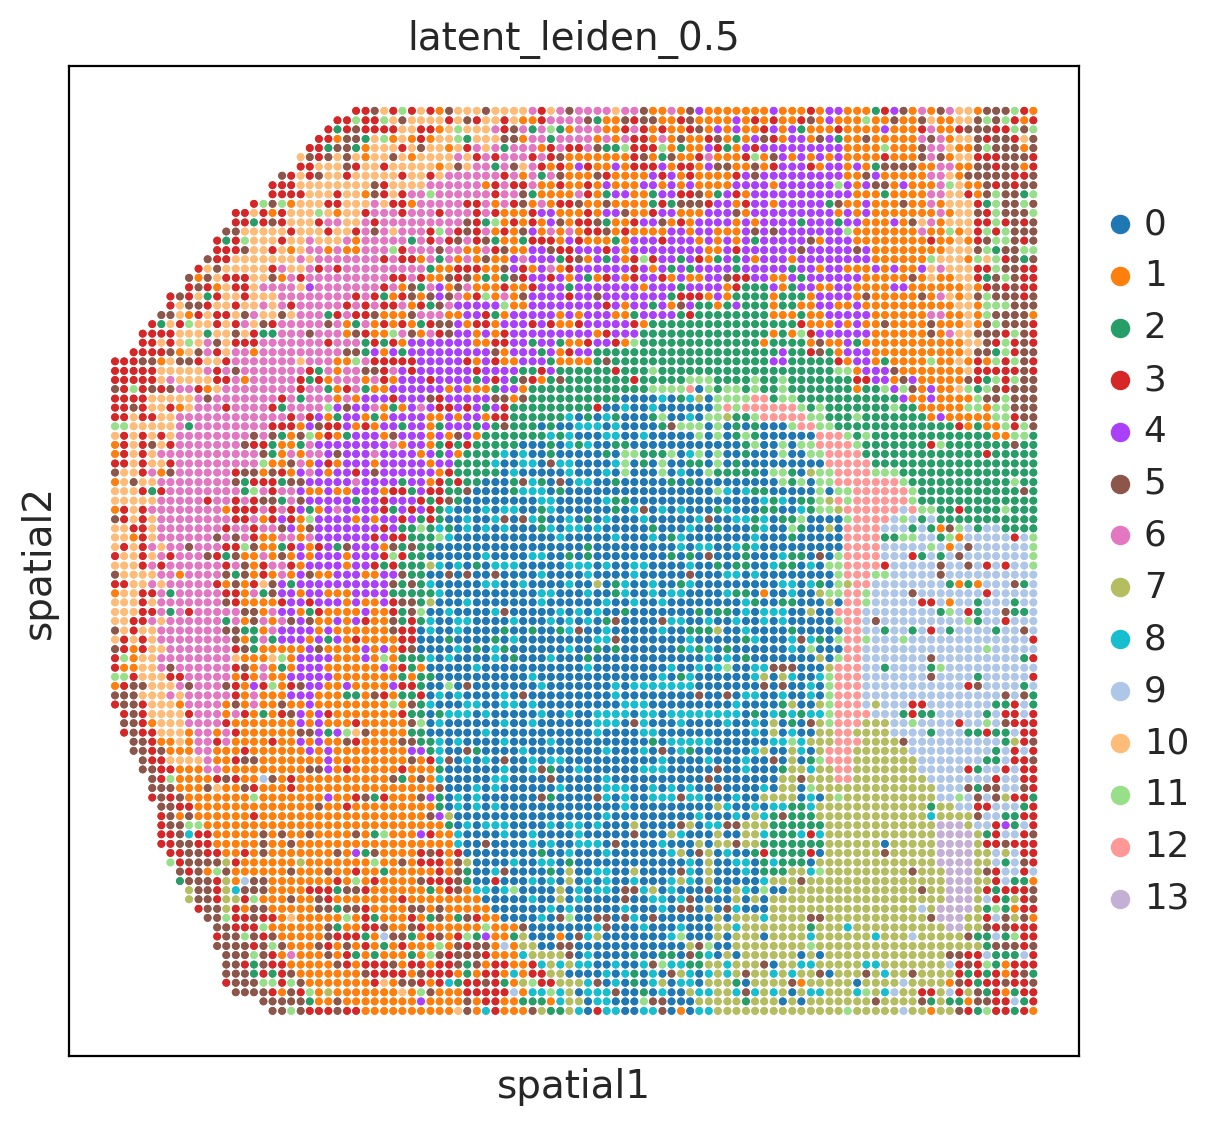

In [15]:
import squidpy as sq
sc.settings.set_figure_params(dpi=100, facecolor='white')

sq.pl.spatial_scatter(model.adata, color=latent_cluster_key, shape=None, figsize=(6, 6))

### Visualize Garfield Latent Space

In [16]:
model.adata.obsm['spatial'][:, 0] *= -1  # 翻转 x 坐标 
model.adata.obsm['spatial'][:, 1] *= -1  # 翻转 y 坐标

<Axes: title={'center': 'Garfield Niches'}, xlabel='spatial1', ylabel='spatial2'>

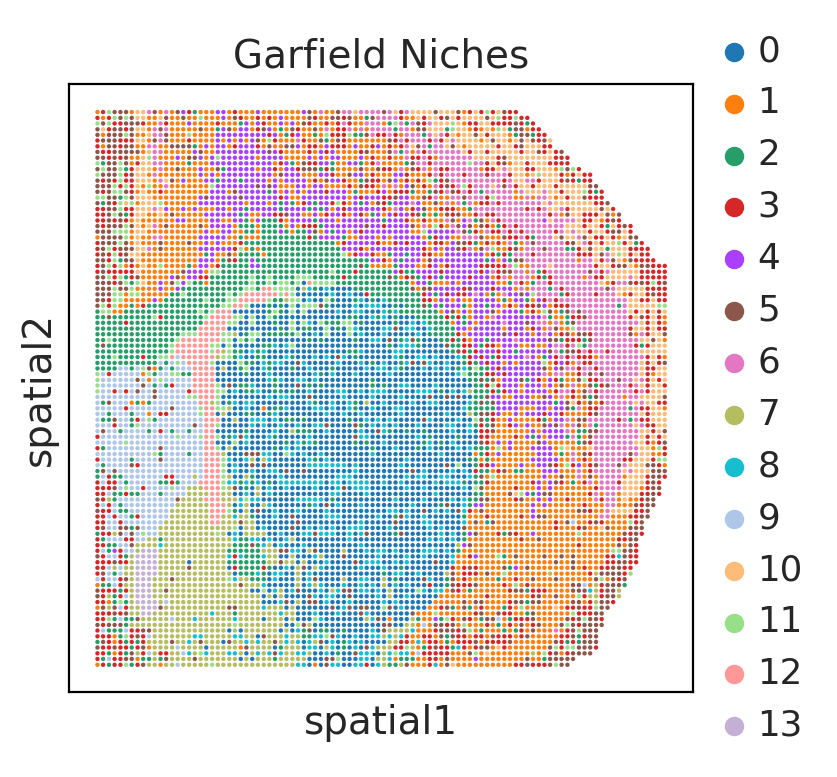

In [19]:
sc.settings.set_figure_params(dpi=100, facecolor='white')

sc.pl.embedding(model.adata, basis='spatial', color=latent_cluster_key,
                title='Garfield Niches', s=10, show=False)

### Save trained model

In [48]:
model_folder_path = f"{workdir}/model"
os.makedirs(model_folder_path, exist_ok=True)

del model.adata.obsm['feat']
model.save(dir_path=model_folder_path,
           overwrite=True,
           save_adata=True,
           adata_file_name="adata_ref.h5ad")

Pickle failed with error: Can't pickle local object 'WeakSet.__init__.<locals>._remove', switching to dill...
Model saved successfully using dill at /pri_exthome/zhouwg/project/Garfield_benchmark/results/sp_multimodal/mouse_brain/model/attr.pkl


In [5]:
from Garfield.model import Garfield

workdir = '/pri_exthome/zhouwg/project/Garfield_benchmark/results/sp_multimodal/mouse_brain'
gf.settings.set_workdir(workdir)
model_folder_path = f"{workdir}/model"

model = Garfield.load(dir_path=model_folder_path,
              adata_file_name="adata_ref.h5ad")

Saving results in: /pri_exthome/zhouwg/project/Garfield_benchmark/results/sp_unimodal/spRNA_slideseqv2
Model loaded successfully using pickle from /pri_exthome/zhouwg/project/Garfield_benchmark/results/sp_unimodal/spRNA_slideseqv2/model/attr.pkl
AnnData object with n_obs × n_vars = 41786 × 3000
    obs: 'cell_type', 'n_genes', 'latent_leiden_0.5', 'latent_leiden_0.8'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'cell_type_colors', 'garfield_latent', 'hvg', 'latent_leiden_0.5', 'latent_leiden_0.5_colors', 'latent_leiden_0.8', 'latent_leiden_0.8_colors', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap', 'feat', 'garfield_latent', 'spatial'
    varm: 'PCs'
    layers: 'counts', 'norm_data'
    obsp: 'connectivities', 'distances', 'garfield_latent_connectivities', 'garfield_latent_distances', 'spatial_connectivities'
--- DATA LOADING AND PREPROCESSING ---
COSINE SIM GRAPH DECODER -> dropout_rate: 0.2
